#### **Indexing**

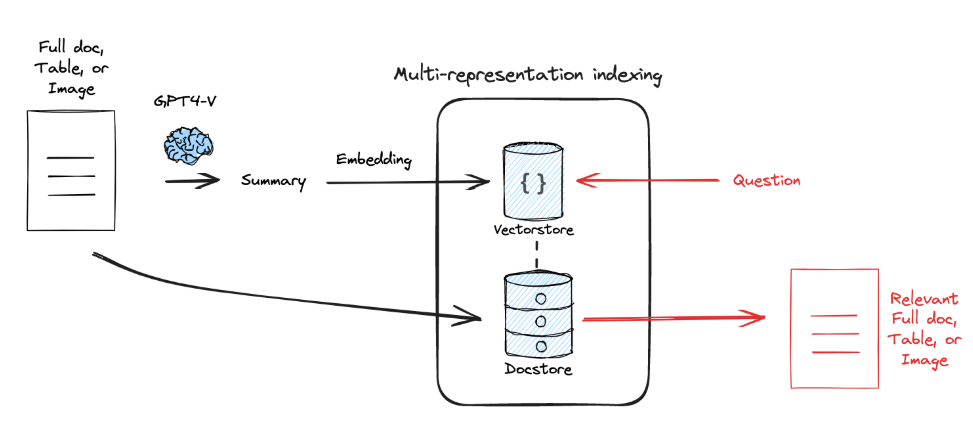

#### **1. Multi-representation Indexing**

Multi-vector retrieval is an advanced search technique where multiple vector representations (embeddings) are created for a single document. This allows the system to match different aspects of the document to a query, improving retrieval accuracy.

- **Why Multi-Vector Retrieval?**
-> Imagine you have a long document. Instead of creating just one vector for the entire document, multi-vector retrieval breaks it down into smaller parts, each with its own vector. This ensures that even if a user's query matches only a small part of the document, it can still be retrieved effectively.

Reference document : https://python.langchain.com/docs/how_to/multi_vector/

There are multiple ways of creating the **multiple vectors and store them in vectorestore per document**, some of them are:


- Smaller chunks: split a document into smaller chunks, and embed those (this is ParentDocumentRetriever).
- Summary: create a summary for each document, embed that along with (or instead of) the document.
- Hypothetical questions: create hypothetical questions that each document would be appropriate to answer, embed those along with (or instead of) the document.

In [17]:
# Importing the necessary libraries and loading the environment variables
import os
import uuid
from langchain_core.documents import Document
from langchain_groq import ChatGroq
from langchain_core.prompts import PromptTemplate,ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from dotenv import load_dotenv
from langchain.storage import InMemoryByteStore
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["MISTRAL_API_KEY"] = os.getenv("MISTRAL_API_KEY")

##### Option 2 : Summary + Entire document

The Summary is store inside the vectorstore and the document is store inside the docstore(Inmemorybytestore)

In [4]:
# Loading the document from the website
loader = WebBaseLoader("https://medium.com/@pankaj_pandey/introduction-to-retrieval-augmented-generation-rag-9209bf8a076d")
docs = loader.load()

loader = WebBaseLoader("https://medium.com/humansdotai/an-introduction-to-ai-agents-e8c4afd2ee8f")
docs.extend(loader.load())

In [5]:
docs

[Document(metadata={'source': 'https://medium.com/@pankaj_pandey/introduction-to-retrieval-augmented-generation-rag-9209bf8a076d', 'title': 'Introduction to Retrieval-Augmented Generation (RAG) | by Pankaj | Medium', 'description': 'The world is advancing rapidly, introducing new technologies and stacks in AI and other areas every day. Large Language Models (LLMs) are a significant innovation in this space. However, LLMs have…', 'language': 'en'}, page_content='Introduction to Retrieval-Augmented Generation (RAG) | by Pankaj | MediumOpen in appSign upSign inWriteSign upSign inMastodonIntroduction to Retrieval-Augmented Generation (RAG)Pankaj·Follow6 min read·Dec 16, 2023--ListenShareRAG systems aim to address the drawbacks of Large Language Models by incorporating factual information during response generation, mitigating issues such as knowledge cutoff and response hallucination.Retrieval Augmented Generation (RAG)The world is advancing rapidly, introducing new technologies and stacks

In [9]:
# create the chain, which will summarise the documents
generate_summary = (
    {"doc":lambda x:x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document :\n\n{doc}")
    | ChatGroq(model="llama-3.3-70b-versatile",temperature=0)
    | StrOutputParser()
)
summaries = generate_summary.batch(docs,{"max_concurrency":1})

In [13]:
summaries

['The article introduces Retrieval-Augmented Generation (RAG), a framework that aims to improve the accuracy and reliability of Large Language Models (LLMs) by incorporating factual information from external knowledge bases during response generation. RAG addresses the drawbacks of LLMs, such as knowledge cutoff and response hallucination, by providing access to up-to-date facts and verifiable sources.\n\n**Key Points:**\n\n1. **Purpose of RAG:** Grounding LLMs on external knowledge for improved responses, overcoming inconsistencies in LLM-generated answers, and reducing opportunities for sensitive data leakage.\n2. **Benefits of RAG:** Accuracy and fact-checking, reduced bias and hallucination, and lower maintenance costs.\n3. **How RAG Works:** RAG consists of two phases: retrieval and content generation. In the retrieval phase, algorithms search for and retrieve relevant information from external knowledge bases, which is then used in the generative phase to synthesize an answer.\n4

In [19]:
# Create the embeddings and store them inside the vectorstore
model_name = "BAAI/bge-small-en"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
hf_embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="summaries",embedding_function=hf_embeddings)

# The storage layer for the parent documents
Inmemory_store = InMemoryByteStore()
id_key = "doc_id"

# retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=Inmemory_store,
    id_key=id_key,
)

doc_ids = [str(uuid.uuid4()) for _ in docs]
doc_ids

C:\Users\admin\AppData\Local\Temp\ipykernel_19224\2179157102.py:5: LangChainDeprecationWarning: The class `HuggingFaceBgeEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  hf_embeddings = HuggingFaceBgeEmbeddings(
c:\Users\admin\anaconda3\envs\env_langchain_tutorial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['b1d4f72c-5508-4c05-840b-68798ef9c17e',
 '0cded4b3-13d6-43b7-b40f-f34bbf4b40aa']

In [20]:
# Linked the docs to the summaries
summary_docs = [Document(page_content=s, metadata={id_key:doc_ids[i]}) for i,s in enumerate(summaries)]
summary_docs

[Document(metadata={'doc_id': 'b1d4f72c-5508-4c05-840b-68798ef9c17e'}, page_content='The article introduces Retrieval-Augmented Generation (RAG), a framework that aims to improve the accuracy and reliability of Large Language Models (LLMs) by incorporating factual information from external knowledge bases during response generation. RAG addresses the drawbacks of LLMs, such as knowledge cutoff and response hallucination, by providing access to up-to-date facts and verifiable sources.\n\n**Key Points:**\n\n1. **Purpose of RAG:** Grounding LLMs on external knowledge for improved responses, overcoming inconsistencies in LLM-generated answers, and reducing opportunities for sensitive data leakage.\n2. **Benefits of RAG:** Accuracy and fact-checking, reduced bias and hallucination, and lower maintenance costs.\n3. **How RAG Works:** RAG consists of two phases: retrieval and content generation. In the retrieval phase, algorithms search for and retrieve relevant information from external know

In [22]:
list(zip(doc_ids,docs))

[('b1d4f72c-5508-4c05-840b-68798ef9c17e',
  Document(metadata={'source': 'https://medium.com/@pankaj_pandey/introduction-to-retrieval-augmented-generation-rag-9209bf8a076d', 'title': 'Introduction to Retrieval-Augmented Generation (RAG) | by Pankaj | Medium', 'description': 'The world is advancing rapidly, introducing new technologies and stacks in AI and other areas every day. Large Language Models (LLMs) are a significant innovation in this space. However, LLMs have…', 'language': 'en'}, page_content='Introduction to Retrieval-Augmented Generation (RAG) | by Pankaj | MediumOpen in appSign upSign inWriteSign upSign inMastodonIntroduction to Retrieval-Augmented Generation (RAG)Pankaj·Follow6 min read·Dec 16, 2023--ListenShareRAG systems aim to address the drawbacks of Large Language Models by incorporating factual information during response generation, mitigating issues such as knowledge cutoff and response hallucination.Retrieval Augmented Generation (RAG)The world is advancing rapid

In [23]:
# Add the summary_docs into the vectorstore and parent document into docstore
retriever.vectorstore.add_documents(documents=summary_docs)
retriever.docstore.mset(list(zip(doc_ids,docs)))

In [24]:
retriever.docstore.mget(doc_ids)

[Document(metadata={'source': 'https://medium.com/@pankaj_pandey/introduction-to-retrieval-augmented-generation-rag-9209bf8a076d', 'title': 'Introduction to Retrieval-Augmented Generation (RAG) | by Pankaj | Medium', 'description': 'The world is advancing rapidly, introducing new technologies and stacks in AI and other areas every day. Large Language Models (LLMs) are a significant innovation in this space. However, LLMs have…', 'language': 'en'}, page_content='Introduction to Retrieval-Augmented Generation (RAG) | by Pankaj | MediumOpen in appSign upSign inWriteSign upSign inMastodonIntroduction to Retrieval-Augmented Generation (RAG)Pankaj·Follow6 min read·Dec 16, 2023--ListenShareRAG systems aim to address the drawbacks of Large Language Models by incorporating factual information during response generation, mitigating issues such as knowledge cutoff and response hallucination.Retrieval Augmented Generation (RAG)The world is advancing rapidly, introducing new technologies and stacks

In [27]:
query = "What is agent ?"
sub_docs = vectorstore.similarity_search(query,k=1)
sub_docs

[Document(metadata={'doc_id': '0cded4b3-13d6-43b7-b40f-f34bbf4b40aa'}, page_content='The article provides an introduction to Artificial Intelligence (AI) Agents, which are intelligent systems that can perform tasks, make decisions, and interact with their environment autonomously. These agents are powered by machine learning, natural language processing, and other cutting-edge technologies, and can learn from data, adapt to new information, and execute complex functions independently.\n\nThe article explores the functionalities of AI Agents, including their ability to navigate their environments, accomplish goals, and interact with humans. It also discusses the technology behind their intelligence, including rule-based systems, decision-making, and machine learning.\n\nAI Agents have various applications across industries, including customer service, healthcare, finance, energy, transportation, and gaming. They can perform tasks such as data analysis, decision-making, and problem-solvi

##### Option3 : Hypothetical Question

An LLM can also be used to generate a list of hypothetical questions that could be asked of a particular document, which might bear close semantic similarity to relevant queries in a RAG application. These questions can then be embedded and associated with the documents to improve retrieval.

In [28]:
# Import the necessary documents
from typing import List
from pydantic import BaseModel, Field

In [29]:
# create the class to define the output
class HypotheticalQuestion(BaseModel):
    """ Generate the Hypothetical questions """
    questions: List[str]=Field(...,description="List of questions")

chain = (
    {'doc':lambda x:x.page_content}
    | ChatPromptTemplate.from_template(
        "Generate a list of exactly 3 hypothetical questions that the below document could be used to answer:\n\n{doc}")
    | ChatGroq(model="llama-3.3-70b-versatile",temperature=0).with_structured_output(HypotheticalQuestion)
    | (lambda x:x.questions)
)

In [32]:
chain.invoke(docs[1])

['What would happen if AI Agents were to become the primary customer service providers across all industries?',
 'How would the economy change if AI Agents were able to completely automate all repetitive tasks?',
 'What would be the implications on human employment if AI Agents were to become capable of performing all tasks currently done by humans?']

In [33]:
# Batch chain over documents to generate hypothetical questions
hypothetical_questions = chain.batch(docs,{"max_concurrency":2})

In [34]:
hypothetical_questions

[['What would happen if RAG systems were widely adopted in customer service chatbots?',
  'How might the development of RAG impact the field of natural language processing?',
  'What are the potential consequences of relying on RAG for generating personalized responses in sensitive applications?'],
 ['What would happen if AI Agents were to become the primary customer service providers across all industries?',
  'How would the development of Artificial General Intelligence impact the role of AI Agents in the future?',
  'What are the potential consequences of relying solely on AI Agents for decision-making in high-stakes fields like healthcare and finance?']]

In [35]:
model_name = "BAAI/bge-small-en"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
hf_embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="hypo-questions", embedding_function=hf_embeddings)

# Byte store for the document storage
store = InMemoryByteStore()
id_key = 'doc_id'

# The retriever
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key
)

# generate the doc_ids
doc_ids = [str(uuid.uuid4())for doc in docs]

In [36]:
doc_ids

['e7628367-5b9e-4ad8-9d88-dcc124b56c1d',
 'cfb6bf5c-6237-4aba-a8d4-c673783bba0d']

In [37]:
hypothetical_questions

[['What would happen if RAG systems were widely adopted in customer service chatbots?',
  'How might the development of RAG impact the field of natural language processing?',
  'What are the potential consequences of relying on RAG for generating personalized responses in sensitive applications?'],
 ['What would happen if AI Agents were to become the primary customer service providers across all industries?',
  'How would the development of Artificial General Intelligence impact the role of AI Agents in the future?',
  'What are the potential consequences of relying solely on AI Agents for decision-making in high-stakes fields like healthcare and finance?']]

In [38]:
# Convert the hypothetical questions into Document object
question_docs = []
for i,questions_lst in enumerate(hypothetical_questions):
    question_docs.extend(Document(page_content=question,metadata={id_key:doc_ids[i]})for question in questions_lst)
question_docs

[Document(metadata={'doc_id': 'e7628367-5b9e-4ad8-9d88-dcc124b56c1d'}, page_content='What would happen if RAG systems were widely adopted in customer service chatbots?'),
 Document(metadata={'doc_id': 'e7628367-5b9e-4ad8-9d88-dcc124b56c1d'}, page_content='How might the development of RAG impact the field of natural language processing?'),
 Document(metadata={'doc_id': 'e7628367-5b9e-4ad8-9d88-dcc124b56c1d'}, page_content='What are the potential consequences of relying on RAG for generating personalized responses in sensitive applications?'),
 Document(metadata={'doc_id': 'cfb6bf5c-6237-4aba-a8d4-c673783bba0d'}, page_content='What would happen if AI Agents were to become the primary customer service providers across all industries?'),
 Document(metadata={'doc_id': 'cfb6bf5c-6237-4aba-a8d4-c673783bba0d'}, page_content='How would the development of Artificial General Intelligence impact the role of AI Agents in the future?'),
 Document(metadata={'doc_id': 'cfb6bf5c-6237-4aba-a8d4-c673783b

In [40]:
# store the document into docstore and questions into the vectorstore
retriever.vectorstore.add_documents(documents=question_docs)
retriever.docstore.mset(list(zip(doc_ids,docs)))

In [46]:
# try out with some query

# Querying vectorstore will give us the questions similar to query
similar_questions = retriever.vectorstore.similarity_search("Agents and Agentic AI")
print(f"Questions : {similar_questions}")

# Querying the retriever will give us the entire document
similar_document = retriever.invoke("Agents and Agentic AI")
print(f"Document : {similar_document} \n")

Questions : [Document(metadata={'doc_id': 'cfb6bf5c-6237-4aba-a8d4-c673783bba0d'}, page_content='How would the development of Artificial General Intelligence impact the role of AI Agents in the future?'), Document(metadata={'doc_id': 'cfb6bf5c-6237-4aba-a8d4-c673783bba0d'}, page_content='What are the potential consequences of relying solely on AI Agents for decision-making in high-stakes fields like healthcare and finance?'), Document(metadata={'doc_id': 'cfb6bf5c-6237-4aba-a8d4-c673783bba0d'}, page_content='What would happen if AI Agents were to become the primary customer service providers across all industries?'), Document(metadata={'doc_id': 'e7628367-5b9e-4ad8-9d88-dcc124b56c1d'}, page_content='What would happen if RAG systems were widely adopted in customer service chatbots?')]
Document : [Document(metadata={'source': 'https://medium.com/humansdotai/an-introduction-to-ai-agents-e8c4afd2ee8f', 'title': 'An Introduction to AI Agents. Artificial Intelligence Agents are the… | by Hum

#### **2. ColBERT**

**ColBERT** (Contextualized Late Interaction over BERT) is an efficient neural retrieval model designed to enhance document search and ranking. It combines deep contextualized understanding with scalability, making it useful for tasks like information retrieval, search engines, and question answering.

ColBERT is primarily used to improve the efficiency and accuracy of search systems while maintaining the **deep contextual understanding** provided by BERT-like models. Unlike traditional dense retrieval methods (like DPR) or lexical approaches (like BM25), ColBERT provides a balance between efficiency and effectiveness in **document ranking**.

ColBERT introduces a Late Interaction mechanism:

1. **Token-wise embeddings:** It represents queries and documents as token embeddings using BERT.
2. **MaxSim operation:** Instead of compressing embeddings into a single vector (as in dense retrieval), it computes the maximum similarity score between each query token and document token.
3. **Efficient Indexing:** Unlike fully dense models, it allows for pre-indexing token embeddings, making search more efficient.

**How ColBERT Works in RAG**
1. **Query Encoding:** The user’s question is tokenized and encoded using BERT, producing contextual embeddings.
2. **Document Indexing:** Each document in the knowledge base is also encoded at the token level, allowing for precomputed embeddings.
3. **Late Interaction (MaxSim):** Instead of compressing embeddings into a single vector (as in dense retrieval), ColBERT keeps per-token embeddings and computes the maximum similarity between query tokens and document tokens.
4. **Ranking and Retrieval:** The top-ranked relevant documents are selected and passed to the LLM for answer generation.
5. **Generation:** The LLM uses retrieved documents as context to provide a fact-based response.


##### How MaxSim Works in the ColBERT ?

1️⃣ **Precomputed Token Embeddings (Avoids Re-encoding)**
In standard cross-encoders, both the query and document need to be re-encoded every time a search happens.
ColBERT precomputes and stores document embeddings in an index.
At query time, only the query tokens need to be encoded, which significantly reduces computational cost.
Time saved: No need to reprocess documents on every query!

2️⃣ **Efficient Nearest Neighbor Search (FAISS / IVF + PQ)**
Instead of scanning all document tokens for similarity, ColBERT uses Approximate Nearest Neighbor (ANN) techniques.
It stores token embeddings in an index structure (like FAISS, IVF, or HNSW), which allows fast lookups.
Instead of brute-force comparisons, ColBERT only searches a small subset of document tokens that are likely to be relevant.
Time saved: Instead of scanning millions of tokens, only the most relevant ones are considered!

🔹 Example: Instead of comparing "symptoms" to all tokens in 1 million documents, ANN helps find the top 100 most similar tokens quickly.

3️⃣ **MaxSim Uses Parallel Computation (Batch Processing)**
ColBERT does not compute token-token similarity sequentially.
Instead, it processes all query-document token pairs in parallel using GPUs.
Matrix multiplication (dot product) is very fast on GPUs, so computing millions of similarities at once is optimized.
Time saved: Instead of computing similarities token by token, the model processes everything in parallel.


**It requires GPU for the processing of documents to create the precomputed embeddings.**

You can check the implementation at : https://python.langchain.com/docs/integrations/retrievers/ragatouille/